## Packages and functions

In [1]:
import pandas as pd
import math
import random
import numpy as np
import pylab as pl
import scipy.special as ss
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import sklearn
from scipy.stats import norm
from scipy.stats import chi
from scipy.stats import chi2
from sklearn.linear_model import LinearRegression
import seaborn as sns

np.random.seed(2035909)

In [2]:
def tau_bounce_sphere(x,v,r,C):
    D = (2*(np.dot(v,x-C)))**2 - 4*np.dot(v,v)*(np.dot(x-C,x-C)-r**2)
    if (D<0):
        tau = np.nan
    elif (D==0):
        tau = -(np.dot(v,x-C))/(np.dot(v,v))
    else:
        tau = min((-2*np.dot(v,x-C) + np.sqrt(D))/(2*np.dot(v,v)),(-2*np.dot(v,x-C) - np.sqrt(D))/(2*np.dot(v,v)))
    return tau

In [3]:
def random_time(a,b,y):
    if b == 0:
        if a > 0:
            return np.log(y)/(-float(a))
        else:
            return -1
    elif b > 0:
        if a >= 0:
            return -a/float(b) + np.sqrt(a**2/float(b**2) - 2*np.log(y)/float(b))
        else:
            return -a/float(b) + random_time(0,b,y)
    else:
        if a > 0:
            if np.log(y) >= a**2/float(2*b):
                return -a/float(b) - np.sqrt(a**2/float(b**2) - 2*np.log(y)/float(b))
            else:
                return -1
        else:
            return -1

In [4]:
def resample_velocity(dim):
    mean = [0]*dim
    cov = np.eye(dim)
    return np.random.multivariate_normal(mean,cov)

In [5]:
def flip_BPS(x,v,mu,V):
    gradient = np.dot(V,(x-mu))
    return v-2*((np.dot(v,gradient))/float((np.dot(gradient,gradient))))*gradient

In [6]:
def reflection(v,n):
    """Return specular reflection"""
    return v-2*(np.dot(v,n)/float((np.dot(n,n))))*n

In [7]:
def normal_sphere(x_hit,C):
    """Return normal for incoming vector on sphere"""
    return x_hit-C

In [8]:
def Phi_norm(x):
    """ Phi(x): R^d -> R"""
    return np.array([(np.dot(v,v)) for v in x])

## Bouncy Particle Sampler

In [9]:
class BPS():
    def __init__(self,x0,dim,mu,V,final_time,boundary = np.array([[0,0],1])):
        self.dim = dim
        self.x0 = x0
        self.mu = mu
        self.V = V
        self.final_time = final_time
        self.boundary = boundary        
        self.simulation = self._simulation()
    
    def description(self):
        print("We are trying to sample from a normal distribution in", self.dim, "-d, with mean", self.mu, "and variance", self.V)
    
    def _simulation(self): 
    
        # Control the total time
        current_time = 0

        # Initialize dataframes
        #T = pd.DataFrame(columns = ['T'])
        #X = pd.DataFrame(columns = range(dim))
        #theta = pd.DataFrame(columns = range(dim))
    
        dict_T = {'T':[]}
        dict_X = {'X':[]}
        dict_theta = {'theta':[]}
    
        dict_T['T'].append(0)
        dict_X['X'].append(self.x0)
    
        initial_theta = resample_velocity(self.dim)
        dict_theta['theta'].append(initial_theta.tolist())

        # Initial values
        #T.loc[1] = 0
        #X.loc[1,] = x0#[0]*self.dim
        #theta.loc[1,] = resample_velocity(dim)

        # Define the refresh rate
        #refresh_rate = 0.3/100*(900+60*2**(math.log(self.dim,2)))
        bounce = -1
        k = 1
        bound = np.nan
    
        current_X = self.x0
        current_theta = initial_theta

        while (current_time < self.final_time):
        
            # Draw uniform r.v. for switching time, refresh time and acceptance of new switching time
            R = np.random.uniform(0,1,[1,2])
            a = np.dot(current_theta,np.dot(self.V,current_X-self.mu))
            b = np.dot(current_theta,np.dot(self.V,current_theta))
            bounce = random_time(a,b,R[0,0])
        
            if self.boundary is not None:
                #print('x',X.loc[k,:])
                #print('v',theta.loc[k,:])
                bound = tau_bounce_sphere(np.array(current_X),np.array(current_theta),self.boundary[1],self.boundary[0])
                if bound<0:
                    bound = np.nan
            
            #refresh_rate = 1.0/20*(30*self.boundary[1]+70)
            #if (refresh_rate < 1 or self.boundary[1] < 1):
            #    refresh_rate = 1.5
            refresh_rate = 5
            if (refresh_rate <= 0):
                refresh = -1
                print('Infinity')
                tau = bounce
            else:
                refresh = -np.log(R[0,1])/float(refresh_rate)
                #print('refresh',refresh)
                tau = np.nanmin([bounce,refresh,bound])
            
            #print(tau)
            # Update time and path
            #T.loc[k+1] = T.loc[k] + tau
            #X.loc[k+1,:] = X.loc[k,:] + theta.loc[k,:]*tau
        
        
            current_X = current_X + current_theta*tau
            
        
            dict_T['T'].append(current_time + tau)
            dict_X['X'].append(current_X.tolist())
            #theta.loc[k+1,:] = theta.loc[k,:]
            #print(X.loc[k+1,:])
            
            #print('Old v',theta.loc[k,:])
            if tau == refresh: # refresh
                update_theta = resample_velocity(self.dim)
                #theta.loc[k+1,:] = resample_velocity(dim)
            elif tau == bound: # bound
                n = normal_sphere(current_X,self.boundary[0])
                #print('n',n)
                update_theta = reflection(current_theta,n)
                #theta.loc[k+1,:] = reflection(theta.loc[k,:],n)
                #print('New v',theta.loc[k+1,:])
            else: # bounce
                update_theta = flip_BPS(current_X,current_theta,self.mu,self.V)
                #theta.loc[k+1,:] = flip_BPS(current_X.values,theta.loc[k,:].values,mu,V)
            
            k = k+1
            current_theta = update_theta
            dict_theta['theta'].append(current_theta.tolist())
            #current_time = T.loc[k].item()
            current_time = current_time + tau
    
        T = pd.DataFrame.from_dict(dict_T)
        X = pd.DataFrame.from_dict(dict_X)
        theta = pd.DataFrame.from_dict(dict_theta)
        
        return T,pd.DataFrame(X['X'].values.tolist()),pd.DataFrame(theta['theta'].values.tolist())
    
    def mean_and_covariance(self):
        T,X,theta = self.simulation
        d = X.shape[1]
        n_points = T.shape[0]

        k = 1
        means = np.zeros(d)
        covariance = np.zeros((d,d))
        T_max = T.loc[n_points-1,'T']

        t_prev= T.loc[k-1,'T']
        x_prev= X.loc[k-1,:].values

        while k <= n_points-1:
            t_now = T.loc[k,'T']
            x_now = X.loc[k,:].values

            means = means + (t_now-t_prev)*(x_prev+x_now)/(float(2)*T_max)
            covariance = covariance + (t_now-t_prev)*((1/(float(6)*T_max))*(2*np.multiply.outer(x_now,x_now) + np.multiply.outer(x_now,x_prev) + np.multiply.outer(x_prev,x_now) + 2*np.multiply.outer(x_prev,x_prev)))
            t_prev = t_now
            x_prev = x_now
            k = k+1

            covariance = covariance - np.multiply.outer(means,means)

        return means, covariance
    
    def plot_path(self):
        fig, ax = plt.subplots()
        T,X,theta = self.simulation
        if self.dim == 1:
            plt.xlabel('t')
            plt.ylabel('X')
            plt.plot(T,X)
        elif self.dim == 2:
            plt.xlabel('X1(t)')
            plt.ylabel('X2(t)')
            plt.plot(X.loc[:,0], X.loc[:,1])
            
        circ=plt.Circle(self.boundary[0], radius=self.boundary[1],fill=False)
        ax.add_patch(circ)
        plt.axis('equal')
        
        plt.grid(True)
        plt.show()
    
    def sample_traj(self,m):
        T,X,theta = self.simulation
        n_points = T.shape[0]-1
        tau = T.loc[n_points,'T']
        dim = X.shape[1]
        sample = pd.DataFrame(columns = range(dim))

        for i in range(1,m):
            t = i*tau/m
            index = np.argmax(T.loc[:,'T']>t)-1
            traj = X.iloc[index,:].values+(t-(T.loc[index,'T']))*np.int64(theta.iloc[index,:].values)
            sample.loc[i,:] = traj
        return sample

## Metropolis-Hastings

In [10]:
def mh_sampler(x0,target_fn,prop_fn,Phi,L,iterations = 100,target_fn_kwargs={},prop_fn_kwargs = {}):
    """Simple metropolis hastings.
    
    Arguments:
    x0: starting point of the chain
    target_fn: target p.d.f.
    prop_fn: proposal p.d.f.
    target_fn_kwargs: extra arguments for target function
    prop_fn_kwargs: extra arguments for proposal function
    L: bound to cross 
    iterations: number of mcmc iterations
    
    Returns:
    A Markov chain on the lowermost sample
    
    """
    dim = x0.size
    
    # Initialize chain, acceptance rate
    chain = np.zeros((iterations,dim))
    accept_rate = np.zeros(iterations)
    target = np.zeros((iterations,dim))
    
    random_uniform = np.random.uniform(0,1,iterations)
    
    # First samples
    chain[0,:] = x0
    target0 = target_fn(x0,**target_fn_kwargs)
    target[0,:] = target0
    
    naccept = 0
    for i in range(1,iterations):
        
        # propose
        x_star, factor = prop_fn(x0,**prop_fn_kwargs)
        
        # hastings-ratio
        target_star = target_fn(x_star,**target_fn_kwargs)
        H = (target_star/float(target0)) * factor

        # accept/reject step
        if (random_uniform[i] < H) & (Phi([x_star]) > L):
            x0 = x_star
            target0 = target_star
            naccept += 1
            #print(Phi([x_star]),L)
        
        # update chain
        chain[i,:] = x0
        target[i,:] = target0
        accept_rate[i] = naccept/float(i)
    
    return chain, accept_rate, target

In [11]:
def gaussian_proposal(x,cov):
    # Draw x_star
    x_star = np.random.multivariate_normal(x, cov)
    # x_star = x + np.random.randn()*sigma
    
    # proposal ratio factor
    factor = 1
    return x_star, factor

In [12]:
def normal(x,mu,cov):
    return np.exp(-0.5*(np.matmul(np.matmul((x-mu).T,cov),x-mu)))

## Estimation probabilities outside n-ball

### Algorithm BS

In [13]:
def p_estimation_mnorm(N,T,q,mean,cov,Phi):
    
    st = time.time()
    dim = mean.size

    m=1
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    L_max = phi[0]
    #print(phi)
    ed = time.time()
    #print(ed-st)
    all_L = [L]

    while L < q:   # as long as there are particles below q
        x0 = X[np.random.randint(2,N)]

        # Run a Markov chain on the lowermost sample
        st = time.time()
        bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,np.sqrt(L)]))
        _,process,_ = bps.simulation
        ed = time.time()
        #print('Markov chain takes',ed-st)
        
        x_star = [item for sublist in process.tail(1).values for item in sublist]
        
        #print('L',L)
        #print('x_star',x_star,'with',Phi(x_star))

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        L_max = max(L,L_max)
        all_L.append(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m,all_L

### Algorithm MH

In [14]:
def p_estimation(N,T,q,target_fn,prop_fn,Phi,target_fn_kwargs,prop_fn_kwargs):

    m=1
    mean = target_fn_kwargs['mu']
    cov = target_fn_kwargs['cov']
    dim = mean.size
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    L_max = phi[0]
    all_L = [L]

    while L < q:   # as long as there are particles below q
        x0 = X[np.random.randint(2,N)]
        
        # Run a Markov chain on the lowermost sample
        process,_,_ = mh_sampler(x0 = x0,
               target_fn = target_fn,
               prop_fn = prop_fn,
               Phi = Phi,
               L = L,
               iterations = T,
               target_fn_kwargs = target_fn_kwargs,
               prop_fn_kwargs = prop_fn_kwargs)
        
        #print(process)
        x_star = process[-1]

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        #phi = np.array(phi)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        #L_max = max(L,L_max)
        all_L.append(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m,all_L

## Computations

In [124]:
columns = ['time_bs','time_mh']
dimension = range(1,101)

df_tc = pd.DataFrame(index = dimension, columns = columns)
df_tc = df_tc.fillna(0)

N = 100
T = 20
L = 1

for i in range(0,len(dimension)):
    dim = dimension[i]
    x0 = np.array([2]*dim)
    mean = np.array([0]*dim)
    cov = np.eye(dim)
    cov_prop = 2*np.eye(dim)
    
    # Time complexity bouncy sampler
    start_bs = time.time()
    bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,L]))
    _,process_bs,_ = bps.simulation
    end_bs = time.time()

    # Time complexity mh sampler
    start_mh = time.time()
    process_mh,_,_ = mh_sampler(x0 = x0, target_fn = normal,
               prop_fn = gaussian_proposal, Phi = Phi_norm, L = L, iterations = T,
               target_fn_kwargs = {'mu':mean,'cov':cov},
               prop_fn_kwargs = {'cov':cov_prop})
    end_mh = time.time()
    
    # Update results
    df_tc.iloc[i,0] = end_bs-start_bs
    df_tc.iloc[i,1] = end_mh-start_mh
    

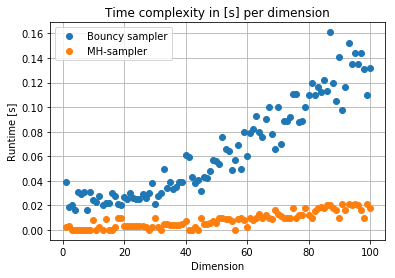

In [125]:
plt.grid(True, which="both")

plt.plot(dimension,df_tc['time_bs'],'o',label = 'Bouncy sampler')
plt.plot(dimension,df_tc['time_mh'],'o',label = 'MH-sampler')
plt.title('Time complexity in [s] per dimension')
plt.xlabel('Dimension')
plt.ylabel('Runtime [s]')
plt.legend(loc='best')
#plt.yscale('log')

plt.show()

In [107]:
def p_estimates(K,dim):
    N = 100
    T = 20
    q = 6*np.sqrt(2*dim)+dim
    
    cov_prop = 2*np.eye(dim)
    mu_target = np.array([0]*dim)
    cov_target = np.eye(dim)

    columns = ['p_est_mh','p_est_bs','m_mh','m_bs','time_mh','time_bs']
    #columns = ['p_est_bs','m_bs','time_bs']
    #columns = ['p_est_mh','m_mh','time_mh']
    index = range(1,K)

    df_K = pd.DataFrame(index = index, columns = columns)

    for k in range(0,K):
        print('mh is busy, in cycle:',k)
        start_mh = time.time()
        p_mh,m_mh,L_mh = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, 
                                target_fn_kwargs = {'mu':mu_target,'cov':cov_target},
                                prop_fn_kwargs = {'cov':cov_prop})
        end_mh = time.time()
        
        print('bs is busy')
        start_bs = time.time()
        p_bs,m_bs,L_bs = p_estimation_mnorm(N,T,q,mu_target,cov_target,Phi_norm)
        end_bs = time.time()
        
        df_K.loc[k+1,'p_est_mh'] = p_mh
        df_K.loc[k+1,'p_est_bs'] = p_bs
        df_K.loc[k+1,'m_mh'] = m_mh
        df_K.loc[k+1,'m_bs'] = m_bs
        df_K.loc[k+1,'time_mh'] = end_mh - start_mh
        df_K.loc[k+1,'time_bs'] = end_bs - start_bs
    
    return df_K

In [108]:
all_estimates = {}

In [109]:
groups = [2,4,8,16,32,64]#,256,512,1024]
K = 10 # number of simulations

for grp in groups:
    #do some calcs to get a dataframe called 'df'
    print(grp,'in progress')
    df = p_estimates(K,grp)
    all_estimates[grp] = df

#all_estimates.to_csv('all_estimates',index = False)

(2, 'in progress')
('mh is busy, in cycle:', 0)
bs is busy
('mh is busy, in cycle:', 1)
bs is busy
('mh is busy, in cycle:', 2)
bs is busy
('mh is busy, in cycle:', 3)
bs is busy
('mh is busy, in cycle:', 4)
bs is busy
('mh is busy, in cycle:', 5)
bs is busy
('mh is busy, in cycle:', 6)
bs is busy
('mh is busy, in cycle:', 7)
bs is busy
('mh is busy, in cycle:', 8)
bs is busy
('mh is busy, in cycle:', 9)
bs is busy
(4, 'in progress')
('mh is busy, in cycle:', 0)
bs is busy
('mh is busy, in cycle:', 1)
bs is busy
('mh is busy, in cycle:', 2)
bs is busy
('mh is busy, in cycle:', 3)
bs is busy
('mh is busy, in cycle:', 4)
bs is busy
('mh is busy, in cycle:', 5)
bs is busy
('mh is busy, in cycle:', 6)
bs is busy
('mh is busy, in cycle:', 7)
bs is busy
('mh is busy, in cycle:', 8)
bs is busy
('mh is busy, in cycle:', 9)
bs is busy
(8, 'in progress')
('mh is busy, in cycle:', 0)
bs is busy
('mh is busy, in cycle:', 1)
bs is busy
('mh is busy, in cycle:', 2)
bs is busy
('mh is busy, in cycle:

In [110]:
all_estimates

{2:        p_est_mh     p_est_bs m_mh m_bs time_mh time_bs
 1    0.00101331  0.000742052  687  718    1.75   11.92
 2   0.000705684   0.00113177  723  676   1.824  11.371
 3    0.00126406   0.00120211  665  670   1.682  11.314
 4   0.000749548   0.00121426  717  669   1.793  11.139
 5    0.00101331   0.00061306  687  737   1.804  12.263
 6    0.00122652  0.000467362  668  764   1.696  12.558
 7     0.0013699  0.000812302  657  709   1.646  11.715
 8   0.000796138   0.00100318  711  688   1.801  11.297
 9   0.000880311  0.000889203  701  700   1.793  11.852
 10  0.000677878  0.000993148  727  689   1.839  11.392,
 4:        p_est_mh     p_est_bs m_mh m_bs time_mh time_bs
 1   0.000279929   0.00060693  815  738     2.1   13.74
 2   0.000332086  0.000588903  798  741   2.063  14.214
 3   0.000187265  0.000352727  855  792   2.189  15.202
 4   0.000367196   0.00060693  788  738   2.002  13.814
 5    0.00035629  0.000406019  791  778   2.017  14.803
 6   0.000181703  0.000352727  858  792  

In [74]:
all_estimates[132]

,p_est_bs,m_bs,time_bs
1,2.72479e-07,1505,1404.72
2,3.9126e-07,1469,1321.26
3,8.06736e-07,1397,1221.15
4,7.74948e-07,1401,1614.84
5,1.58356e-07,1559,1752.31
6,4.6416e-07,1452,1600.89
7,2.59125e-07,1510,1558.03
8,4.68848e-07,1451,1369.52
9,1.66516e-07,1554,1443.54
10,3.33142e-07,1485,1387.7


In [111]:
df = pd.read_csv ('C:\Users\mark\Documents\TU Delft\Master thesis\mse_refresh_rate.csv')

In [112]:
df['p'] = chi2.sf(df['q'],df['dim'])

In [116]:
df.head()

,dim,q,p_est_mh,p_est_bs,m_mh,m_bs,time_mh,time_bs,p
0,2,14.0,0.000898,0.000872,699,702,1.783,11.636,0.000912
1,2,14.0,0.000846,0.001833,705,628,1.793,10.391,0.000912
2,2,14.0,0.001227,0.000658,668,730,1.713,12.358,0.000912
3,2,14.0,0.000522,0.000907,753,698,1.908,11.491,0.000912
4,2,14.0,0.000658,0.000854,730,704,1.865,11.630,0.000912


In [115]:
special_df = df.head(119)

In [117]:
new_df = df.groupby(['dim']).mean()

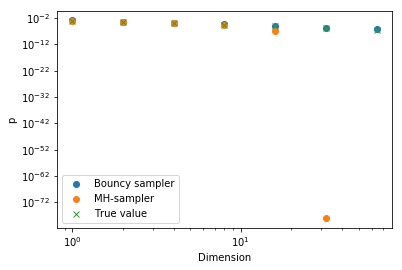

In [118]:
dimension = [1,2,4,8,16,32,64]
plt.plot(dimension,new_df['p_est_bs'],'o',label = 'Bouncy sampler')
plt.plot(dimension,new_df['p_est_mh'],'o',label = 'MH-sampler')
plt.plot(dimension,new_df['p'],'x',label = 'True value')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Dimension')
plt.ylabel('p')

plt.show()

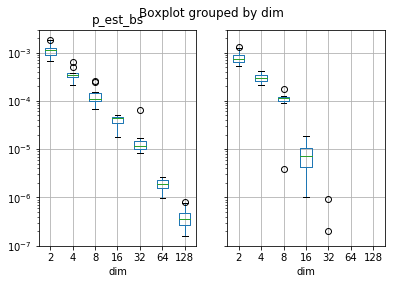

In [92]:
df.boxplot(column=['p_est_bs','p_est_mh'], by='dim')
plt.title('')
plt.yscale('log')
plt.show()

In [93]:
df_melt = special_df.melt(id_vars = 'dim',
                  value_vars = ['p_est_bs',
                                'p_est_mh'],
                  var_name = 'columns')

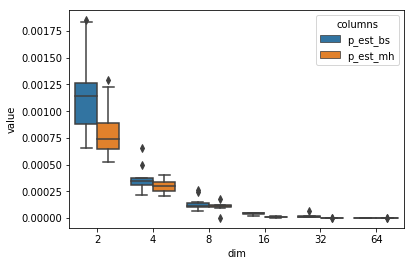

In [95]:
g = sns.boxplot(data = df_melt,
                hue = 'columns', # different colors for different 'cls'
                x = 'dim',
                y = 'value'
                )
#g.figure.get_axes()[0].set_yscale('log')
#sns.plt.title('Boxplot grouped by cls') # You can change the title here
plt.show()

In [75]:
columns = ['acc_rate']
dimension = range(1,101)

df_acc = pd.DataFrame(index = dimension, columns = columns)
df_acc = df_acc.fillna(0)

N = 100
T = 20
L = 1

for i in range(0,len(dimension)):
    dim = dimension[i]
    x0 = np.array([2]*dim)
    mean = np.array([0]*dim)
    cov = np.eye(dim)
    cov_prop = 2*np.eye(dim)

    # Acceptance rate mh sampler
    _,accept_rate,_ = mh_sampler(x0 = x0, target_fn = normal,
               prop_fn = gaussian_proposal, Phi = Phi_norm, L = L, iterations = T,
               target_fn_kwargs = {'mu':mean,'cov':cov},
               prop_fn_kwargs = {'cov':cov_prop})
    
    # Update results
    df_acc.iloc[i,0] = accept_rate[-1]

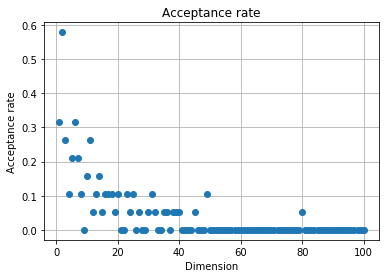

In [76]:
dimension = range(1,101)

plt.grid(True, which="both")

plt.plot(dimension,df_acc['acc_rate'],'o')
plt.title('Acceptance rate')
plt.xlabel('Dimension')
plt.ylabel('Acceptance rate')

plt.show()

In [96]:
def VAR(x):
    y = np.mean(x)
    return np.mean((x-y)**2)

In [97]:
def ESS_per_s(df):
    D = df['dim'].drop_duplicates()
    p = chi2.sf(6*np.sqrt(2*np.array(D))+np.array(D),df=D)
    est = df.groupby(['dim']).mean()[['p_est_mh','p_est_bs']]
    var = df.groupby(['dim']).apply(lambda grp: VAR(grp[['p_est_mh','p_est_bs']]))
    cpu_time = df.groupby(['dim']).mean()[['time_mh','time_bs']]
    n_eff = ((p[:,None]*(1-p[:,None]))/((est.values-p[:,None])**2+var))
    print(n_eff)
    return n_eff/cpu_time.values

In [119]:
ESS = ESS_per_s(df)

         p_est_mh      p_est_bs
dim                            
2    1.356835e+04  6.748607e+03
4    4.814355e+04  1.490576e+04
8    5.056607e+04  1.578611e+04
16   6.808159e+04  7.427094e+04
32   1.884640e+05  1.793927e+05
64   7.818797e+05  1.848162e+06
128  3.081985e+06  6.006138e+06


In [120]:
ESS_s_bs = ESS['p_est_bs']
ESS_s_mh = ESS['p_est_mh']

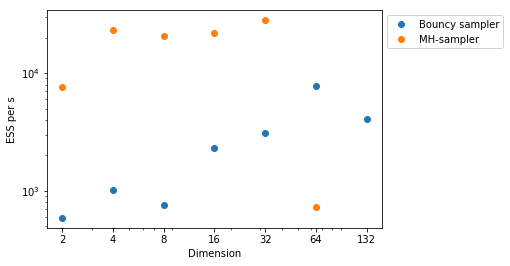

In [138]:
plt.plot(ESS_s_bs,'o',label = 'Bouncy sampler')
plt.plot(ESS_s_mh,'o',label = 'MH-sampler')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Dimension')
plt.ylabel('ESS per s')
plt.xticks(ESS_s_bs.index,('2', '4','8','16','32','64','132'))


plt.show()

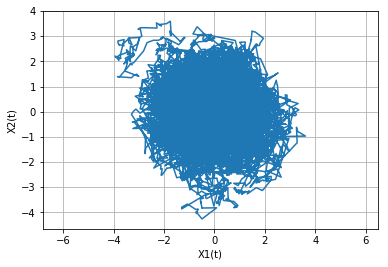

In [19]:
np.random.seed(134304)
%matplotlib inline
bps = BPS([1,1],2,np.array([0,0]),np.linalg.inv(np.array([[1,0],[0,1]])),5000,boundary = np.array([[0,0],0]))
bps.plot_path()

In [127]:
def influence_of_T(K,dim,T):
    N = 100
    q = 6*np.sqrt(2*dim)+dim
    runtime = T
    
    mu_target = np.array([0]*dim)
    cov_target = np.eye(dim)
    cov_prop = 2*np.eye(dim)

    columns = ['T','p_est_bs','m_bs','time_bs']
    #columns = ['T','p_est_mh','m_mh','time_mh']
    index = range(0,K)

    df_T = pd.DataFrame(index = index, columns = columns)

    for k in range(0,K):
        
        #print('mh is busy')
        #start_mh = time.time()
        #p_mh,m_mh = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, 
        #                        target_fn_kwargs = {'mu':mu_target,'cov':cov_target},
        #                        prop_fn_kwargs = {'cov':cov_prop})
        #end_mh = time.time()
        print('bs is busy')
        start_bs = time.time()
        p_bs,m_bs,L_bs = p_estimation_mnorm(N,T,q,mu_target,cov_target,Phi_norm)
        end_bs = time.time()
        
        df_T.loc[k,'T'] = runtime
        df_T.loc[k,'p_est_bs'] = p_bs
        df_T.loc[k,'m_bs'] = m_bs
        df_T.loc[k,'time_bs'] = end_bs - start_bs
        #df_T.loc[k,'p_est_mh'] = p_mh
        #df_T.loc[k,'m_mh'] = m_mh
        #df_T.loc[k,'time_mh'] = end_mh - start_mh
    
    return df_T

In [248]:
T = [1000]#,1000]#,5000]
K = 15 # number of simulations
dim = 4 # dimension
columns = ['T','p_est_bs','m_bs','time_bs']
#columns = ['T','p_est_mh','m_mh','time_mh']
index = range(0)
dfT = pd.DataFrame(index = index, columns = columns)

for t in T:
    #do some calcs to get a dataframe called 'df'
    print(t,'in progress')
    df_new = influence_of_T(K,dim,t)
    dfT = pd.concat([dfT, df_new], ignore_index=True,sort = True)

(1000, 'in progress')
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy
bs is busy


In [249]:
dfT

,T,m_bs,p_est_bs,time_bs
0,1000,777,0.00041012,1395.18
1,1000,800,0.000325477,1440.7
2,1000,743,0.000577184,1334.54
3,1000,808,0.000300332,1448.11
4,1000,783,0.00038612,1409.51
5,1000,756,0.000506491,1348.88
6,1000,776,0.000414263,1394.13
7,1000,732,0.000644655,1311.19
8,1000,789,0.000363524,1398.99
9,1000,832,0.000235965,1493.73


In [70]:
chi2.sf(6*np.sqrt(2*4)+4,4)

0.00032095326442779283

In [250]:
dfTime_bs = pd.read_csv ('C:\Users\mark\Documents\TU Delft\Master thesis\Notebooks\dfTime_bs.csv')

In [25]:
dfT

,T,m_bs,p_est_bs,time_bs
0,20000,685,0.00103389,4783.31
1,20000,749,0.000543407,5262.59
2,20000,721,0.000720013,5038.87
3,20000,701,0.000880311,4882.93
4,20000,722,0.000712812,5074.32


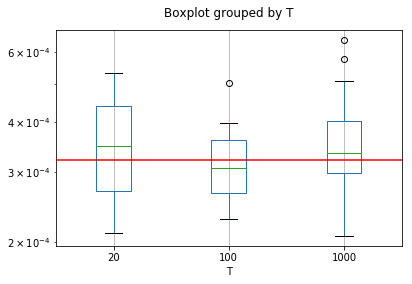

In [251]:
dfTime_bs.boxplot(column='p_est_bs', by='T')
plt.axhline(y=chi2.sf(6*np.sqrt(2*4)+4,4), color='r', linestyle='-')
plt.title('')
plt.yscale('log')
plt.show()

In [252]:
def influence_of_N(K,dim,N):
    q = 6*np.sqrt(2*dim)+dim
    T = 20
    
    mu_target = np.array([0]*dim)
    cov_target = np.eye(dim)

    columns = ['N','p_est_bs','m_bs','time_bs']
    index = range(0,K)

    df_N = pd.DataFrame(index = index, columns = columns)

    for k in range(0,K):
        
        print('bs is busy',k)
        start_bs = time.time()
        p_bs,m_bs,L_bs = p_estimation_mnorm(N,T,q,mu_target,cov_target,Phi_norm)
        end_bs = time.time()
        
        df_N.loc[k,'N'] = N
        df_N.loc[k,'p_est_bs'] = p_bs
        df_N.loc[k,'m_bs'] = m_bs
        df_N.loc[k,'time_bs'] = end_bs - start_bs
    return df_N

In [ ]:
N = [10,100,200,500,1000]
K = 25 # number of simulations
dim = 4 # dimension
columns = ['N','p_est_bs','m_bs','time_bs']
index = range(0)
dfN = pd.DataFrame(index = index, columns = columns)

for n in N:
    #do some calcs to get a dataframe called 'df'
    print(n,'in progress')
    df_new = influence_of_N(K,dim,n)
    dfN = pd.concat([dfN, df_new], ignore_index=True,sort = True)

(10, 'in progress')
('bs is busy', 0)
('bs is busy', 1)
('bs is busy', 2)
('bs is busy', 3)
('bs is busy', 4)
('bs is busy', 5)
('bs is busy', 6)
('bs is busy', 7)
('bs is busy', 8)
('bs is busy', 9)
('bs is busy', 10)
('bs is busy', 11)
('bs is busy', 12)
('bs is busy', 13)
('bs is busy', 14)
('bs is busy', 15)
('bs is busy', 16)
('bs is busy', 17)
('bs is busy', 18)
('bs is busy', 19)
('bs is busy', 20)
('bs is busy', 21)
('bs is busy', 22)
('bs is busy', 23)
('bs is busy', 24)
(100, 'in progress')
('bs is busy', 0)
('bs is busy', 1)
('bs is busy', 2)
('bs is busy', 3)
('bs is busy', 4)
('bs is busy', 5)
('bs is busy', 6)
('bs is busy', 7)
('bs is busy', 8)
('bs is busy', 9)
('bs is busy', 10)
('bs is busy', 11)
('bs is busy', 12)
('bs is busy', 13)
('bs is busy', 14)
('bs is busy', 15)
('bs is busy', 16)
('bs is busy', 17)
('bs is busy', 18)
('bs is busy', 19)
('bs is busy', 20)
('bs is busy', 21)
('bs is busy', 22)
('bs is busy', 23)
('bs is busy', 24)
(200, 'in progress')
('bs is 

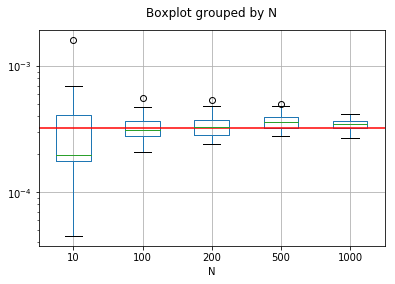

In [254]:
dfN.boxplot(column='p_est_bs', by='N')
plt.axhline(y=chi2.sf(6*np.sqrt(2*4)+4,4), color='r', linestyle='-')
plt.title('')
plt.yscale('log')
plt.show()

### Conditional distribution and convergence

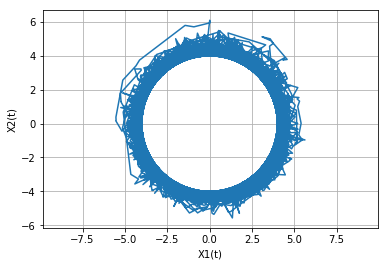

In [34]:
np.random.seed(134304)
%matplotlib inline
bps = BPS([1,4],2,np.array([0,0]),np.linalg.inv(np.array([[1,0],[0,1]])),5000,boundary = np.array([[0,0],4]))
bps.plot_path()

#plt.scatter(Y[:,0],Y[:,1],s=0.8)
#plt.axis('equal')
#plt.grid(True)
#plt.show()

In [16]:
S = bps.sample_traj(10000)

C:\Users\mark\Anaconda3\envs\master_thesis\lib\site-packages\numpy\core\fromnumeric.py:973: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return argmax(axis, out)


In [17]:
np.mean(S)

0   -0.015997
1   -0.161699
dtype: float64

In [18]:
np.cov(S.loc[:,0],S.loc[:,1])

array([[2.917709657885998, 0.15839570856669605],
       [0.15839570856669605, 3.112785567248778]], dtype=object)

### Bounces due to density or boundary?

In [15]:
from collections import Counter

In [16]:
def bps_simulation(x0,dim,mu,V,final_time,boundary,refresh_rate): 
    
    # Control the total time
    current_time = 0

    # Initialize dataframes
    #T = pd.DataFrame(columns = ['T'])
    #X = pd.DataFrame(columns = range(dim))
    #theta = pd.DataFrame(columns = range(dim))
    
    dict_T = {'T':[]}
    dict_X = {'X':[]}
    dict_theta = {'theta':[]}
    
    dict_T['T'].append(0)
    dict_X['X'].append(x0)
    
    initial_theta = resample_velocity(dim)
    dict_theta['theta'].append(initial_theta.tolist())

    # Initial values
    #T.loc[1] = 0
    #X.loc[1,] = x0#[0]*self.dim
    #theta.loc[1,] = resample_velocity(dim)

    # Define the refresh rate
    #refresh_rate = 3
    bounce = -1
    k = 1
    bound = np.nan
    
    current_X = x0
    current_theta = initial_theta
    
    changes = []

    while (current_time < final_time):
        
        # Draw uniform r.v. for switching time, refresh time and acceptance of new switching time
        R = np.random.uniform(0,1,[1,2])
        a = np.dot(current_theta,np.dot(V,current_X-mu))
        b = np.dot(current_theta,np.dot(V,current_theta))
        bounce = random_time(a,b,R[0,0])
        
        if boundary is not None:
            #print('x',X.loc[k,:])
            #print('v',theta.loc[k,:])
            bound = tau_bounce_sphere(np.array(current_X),np.array(current_theta),boundary[1],boundary[0])
            if bound<0:
                bound = np.nan
                    
        if (refresh_rate <= 0):
            refresh = -1
            print('Infinity')
            tau = bounce
        else:
            refresh = -np.log(R[0,1])/float(refresh_rate)
            #print('refresh',refresh)
            tau = np.nanmin([bounce,refresh,bound])
            
        #print(tau)
        # Update time and path
        #T.loc[k+1] = T.loc[k] + tau
        #X.loc[k+1,:] = X.loc[k,:] + theta.loc[k,:]*tau
        
        
        current_X = current_X + current_theta*tau
        
        
        dict_T['T'].append(current_time + tau)
        dict_X['X'].append(current_X.tolist())
        #theta.loc[k+1,:] = theta.loc[k,:]
        #print(X.loc[k+1,:])
            
        #print('Old v',theta.loc[k,:])
        if tau == refresh: # refresh
            update_theta = resample_velocity(dim)
            #theta.loc[k+1,:] = resample_velocity(dim)
            changes.append(0)
        elif tau == bound: # bound
            n = normal_sphere(current_X,boundary[0])
            #print('n',n)
            update_theta = reflection(current_theta,n)
            #theta.loc[k+1,:] = reflection(theta.loc[k,:],n)
            #print('New v',theta.loc[k+1,:])
            changes.append(1)
        else: # bounce
            update_theta = flip_BPS(current_X,current_theta,mu,V)
            #theta.loc[k+1,:] = flip_BPS(current_X.values,theta.loc[k,:].values,mu,V)
            changes.append(2)
            
        k = k+1
        current_theta = update_theta
        dict_theta['theta'].append(current_theta.tolist())
        #current_time = T.loc[k].item()
        current_time = current_time + tau
    
    T = pd.DataFrame.from_dict(dict_T)
    X = pd.DataFrame.from_dict(dict_X)
    theta = pd.DataFrame.from_dict(dict_theta)
        
    return T,pd.DataFrame(X['X'].values.tolist()),pd.DataFrame(theta['theta'].values.tolist()),changes

In [60]:
def percentage_refr(dimensions):
    T = 100
    
    columns = ['refr','boundary','density']
    index = range(0,len(dimensions))

    df_perc = pd.DataFrame(index = index, columns = columns)

    for k in range(len(dimensions)):
        dim = dimensions[k]
        mu_target = np.array([0]*dim)
        cov_target = np.eye(dim)
        R = 6*np.sqrt(2*dim)+dim
        x0 = np.ones(dim)
        x0[0] = R
        _,_,_,changes = bps_simulation(x0,dim,mu_target,cov_target,T,boundary = np.array([np.array([0]*dim),R]),refresh_rate = 0.3/100*(900+60*2**(math.log(dim,2))))
        z = Counter(changes)
        
        df_perc.loc[k,:] = z.values()
    return df_perc

In [61]:
dimensions = [2,4,8,16,32,64,128,256]
df_perc = percentage_refr(dimensions)

In [62]:
df_perc

,refr,boundary,density
0,310,623,630
1,318,815,830
2,356,1368,1370
3,554,1897,1928
4,802,3040,3057
5,1384,5316,5342
6,2550,8499,8506
7,5014,15523,15531


In [20]:
def perc_plot(df_perc):
    # Data
    r = df_perc.index

    # From raw value to percentage
    totals = [i+j+k for i,j,k in zip(df_perc['refr'], df_perc['boundary'], df_perc['density'])]
    greenBars = [i / float(j) * 100 for i,j in zip(df_perc['refr'], totals)]
    orangeBars = [i / float(j) * 100 for i,j in zip(df_perc['boundary'], totals)]
    blueBars = [i / float(j) * 100 for i,j in zip(df_perc['density'], totals)]

    # plot
    barWidth = 0.85
    names = ('2','4','8','16','32','64','128','256')
    # Create green Bars
    plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth,label="Refreshments")
    # Create orange Bars
    plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth,label="Boundary")
    # Create blue Bars
    plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth,label="Density")

    # Custom x axis
    plt.xticks(r, names)
    plt.xlabel("dimension")

    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

    # Show graphic
    plt.show()


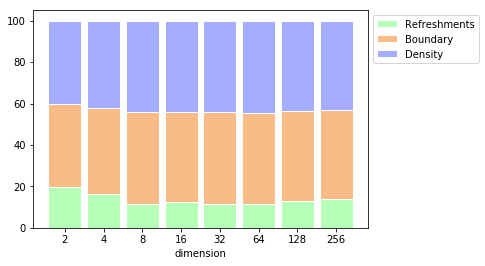

In [63]:
perc_plot(df_perc)

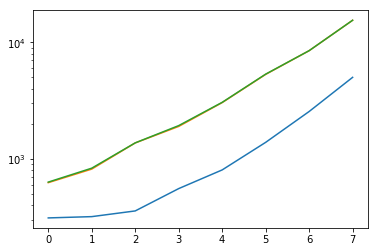

In [64]:
plt.plot(df_perc)
plt.yscale('log')
plt.show()

In [28]:
regressor = LinearRegression()  
regressor.fit(np.array(dimensions).reshape(-1,1), df_perc['boundary'].values) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

908.548412084
[ 58.85022099]


In [227]:
def percentage_refr_radius(dim):
    T = 100
    end_point = 6*np.sqrt(2*dim)+dim
    radius = np.linspace(1, end_point, num=10)
    
    columns = ['refr','boundary','density']
    index = range(0,len(radius))

    df_perc = pd.DataFrame(index = index, columns = columns)
    mu_target = np.array([0]*dim)
    cov_target = np.eye(dim)
    x0 = np.ones(dim)
    

    for k in range(len(radius)):
        R = radius[k]
        x0[0] = R
        refresh_rate = 1.0/T*(30*R+70)
        if refresh_rate < 0:
            refresh_rate = 1.5
        _,_,_,changes = bps_simulation(x0,dim,mu_target,cov_target,T,boundary = np.array([np.array([0]*dim),R]),refresh_rate = refresh_rate)
        z = Counter(changes)
        print(z)
        df_perc.loc[k,:] = z.values()
    return df_perc

In [228]:
dim = 4
df_perc_radius = percentage_refr_radius(dim)

Counter({0: 85, 2: 81, 1: 14})
Counter({0: 163, 2: 124, 1: 97})
Counter({0: 246, 2: 227, 1: 223})
Counter({2: 325, 0: 323, 1: 289})
Counter({1: 441, 2: 424, 0: 366})
Counter({2: 483, 1: 473, 0: 421})
Counter({2: 655, 1: 640, 0: 528})
Counter({2: 702, 1: 674, 0: 540})
Counter({1: 784, 2: 772, 0: 620})
Counter({1: 865, 2: 859, 0: 757})


In [229]:
df_perc_radius

,refr,boundary,density
0,85,14,81
1,163,97,124
2,246,223,227
3,323,289,325
4,366,441,424
5,421,473,483
6,528,640,655
7,540,674,702
8,620,784,772
9,757,865,859


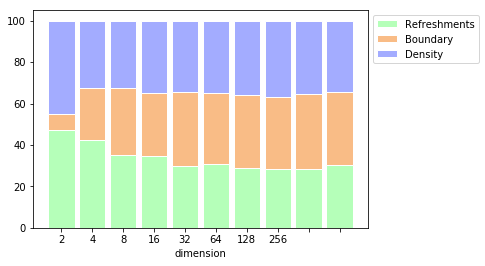

In [230]:
perc_plot(df_perc_radius)

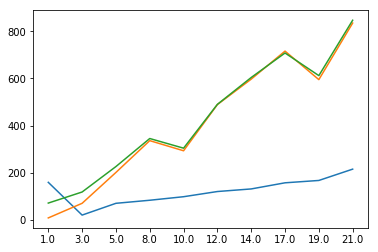

In [194]:
plt.plot(df_perc_radius)
#plt.yscale('log')
plt.xticks(df_perc_radius.index,np.round(np.linspace(1,6*np.sqrt(2*dim)+dim,10)))
plt.show()

In [34]:
T,X,theta,changes = bps_simulation([16,1],2,np.array([0,0]),np.linalg.inv(np.array([[1,0],[0,1]])),5000,boundary = np.array([[0,0],16]))

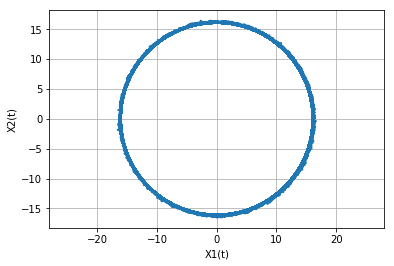

In [17]:
fig, ax = plt.subplots()
plt.xlabel('X1(t)')
plt.ylabel('X2(t)')
plt.plot(X.loc[:,0], X.loc[:,1])
            
circ=plt.Circle([0,0], radius=16,fill=False)
ax.add_patch(circ)
plt.axis('equal')
        
plt.grid(True)
plt.show()

In [18]:
z = Counter(changes)
z.values()

[150526, 319745, 320790]

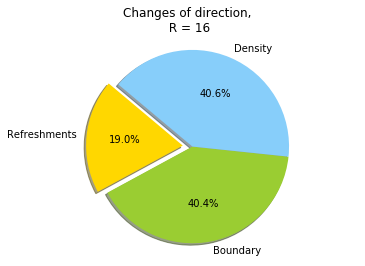

In [19]:
# Data to plot
labels = 'Refreshments', 'Boundary', 'Density'
sizes = z.values()
colors = ['gold', 'yellowgreen', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Changes of direction,\n R = 16')
plt.axis('equal')
plt.show()

### Distribution of thresholds

In [32]:
def p_estimation_mnorm_threshold(N,M,T,mean,cov,Phi):
    
    st = time.time()
    dim = mean.size

    #m=1
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    L_max = phi[0]
    #print(phi)
    ed = time.time()
    #print(ed-st)
    all_L = [L]

    for m in range(1,M):   # as long as there are particles below q
        x0 = X[np.random.randint(2,N)]

        # Run a Markov chain on the lowermost sample
        st = time.time()
        bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,np.sqrt(L)]))
        _,process,_ = bps.simulation
        ed = time.time()
        #print('Markov chain takes',ed-st)
        
        x_star = [item for sublist in process.tail(1).values for item in sublist]
        
        #print('L',L)
        #print('x_star',x_star,'with',Phi(x_star))

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        L_max = max(L,L_max)
        all_L.append(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m,all_L

In [38]:
def p_estimation_threshold(N,M,T,target_fn,prop_fn,Phi,target_fn_kwargs,prop_fn_kwargs):

    #m=1
    mean = target_fn_kwargs['mu']
    cov = target_fn_kwargs['cov']
    dim = mean.size
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    L_max = phi[0]
    all_L = [L]

    for m in range(1,M):   # as long as there are particles below q
        x0 = X[np.random.randint(2,N)]
        
        # Run a Markov chain on the lowermost sample
        process,_,_ = mh_sampler(x0 = x0,
               target_fn = target_fn,
               prop_fn = prop_fn,
               Phi = Phi,
               L = L,
               iterations = T,
               target_fn_kwargs = target_fn_kwargs,
               prop_fn_kwargs = prop_fn_kwargs)
        
        #print(process)
        x_star = process[-1]

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        #phi = np.array(phi)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        #L_max = max(L,L_max)
        all_L.append(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m,all_L

In [40]:
np.random.seed(23948)

N = 100
M = 300
T = 20
dim = 16
q = 6*np.sqrt(2*dim)+dim
    
cov_prop = 2*np.eye(dim)
mu_target = np.array([0]*dim)
cov_target = np.eye(dim)

p_mh,m_mh,L_mh = p_estimation_threshold(N,M,T,normal,gaussian_proposal,Phi = Phi_norm, 
                                target_fn_kwargs = {'mu':mu_target,'cov':cov_target},
                                prop_fn_kwargs = {'cov':cov_prop})

p_bs,m_bs,L_bs = p_estimation_mnorm_threshold(N,M,T,mu_target,cov_target,Phi_norm)

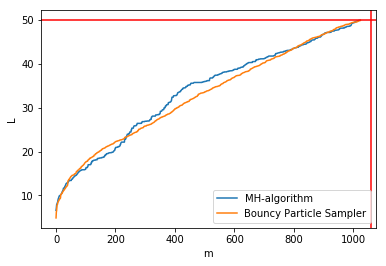

In [57]:
q = 6*np.sqrt(2*dim)+dim
m = np.log(chi2.sf(q,dim))/(np.log(1-1/float(N)))

plt.plot(L_mh, label = 'MH-algorithm')
plt.plot(L_bs, label = 'Bouncy Particle Sampler')
plt.axhline(y=q, color='r', linestyle='-')
plt.axvline(x=m, color='r',linestyle='-')
plt.xlabel('m')
plt.ylabel('L')
plt.legend(loc='best')
plt.show()

In [61]:
print chi2.sf(q,dim)
print p_bs
print p_mh

2.34251766623e-05
3.39187054019e-05
3.42613185878e-05


In [147]:
L_bs[300]

9.7435103831273686

Fix the situation for now. We work with $N=100, T=20$ and the dimension is 16. We run the algorithm to find the rare probability $M = 1000$ times and have a look at the level after iteration $m=300$. 

In [61]:
N = 10
T = 20
dim = 16
q = 6*np.sqrt(2*dim)+dim
    
cov_prop = 2*np.eye(dim)
mu_target = np.array([0]*dim)
cov_target = np.eye(dim)

n_sim = 1000
m = 100
dist_L_bs = []

for j in range(0,n_sim):
    print "Iteration",j
    p_bs,m_bs,L_bs = p_estimation_mnorm_threshold(N,m,T,mu_target,cov_target,Phi_norm)
    dist_L_bs.append(L_bs[m-1])

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

Iteration 594
Iteration 595
Iteration 596
Iteration 597
Iteration 598
Iteration 599
Iteration 600
Iteration 601
Iteration 602
Iteration 603
Iteration 604
Iteration 605
Iteration 606
Iteration 607
Iteration 608
Iteration 609
Iteration 610
Iteration 611
Iteration 612
Iteration 613
Iteration 614
Iteration 615
Iteration 616
Iteration 617
Iteration 618
Iteration 619
Iteration 620
Iteration 621
Iteration 622
Iteration 623
Iteration 624
Iteration 625
Iteration 626
Iteration 627
Iteration 628
Iteration 629
Iteration 630
Iteration 631
Iteration 632
Iteration 633
Iteration 634
Iteration 635
Iteration 636
Iteration 637
Iteration 638
Iteration 639
Iteration 640
Iteration 641
Iteration 642
Iteration 643
Iteration 644
Iteration 645
Iteration 646
Iteration 647
Iteration 648
Iteration 649
Iteration 650
Iteration 651
Iteration 652
Iteration 653
Iteration 654
Iteration 655
Iteration 656
Iteration 657
Iteration 658
Iteration 659
Iteration 660
Iteration 661
Iteration 662
Iteration 663
Iteration 664
Iterat

In [62]:
x1 = -np.log(chi2.sf(dist_L_bs,df = 16))

(array([   6.,   39.,  132.,  274.,  278.,  191.,   60.,   16.,    3.,    1.]),
 array([  7.14989459,   7.9626264 ,   8.7753582 ,   9.58809001,
         10.40082181,  11.21355362,  12.02628543,  12.83901723,
         13.65174904,  14.46448084,  15.27721265]),
 <a list of 10 Patch objects>)

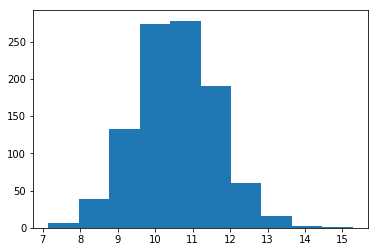

In [63]:
plt.hist(x1)

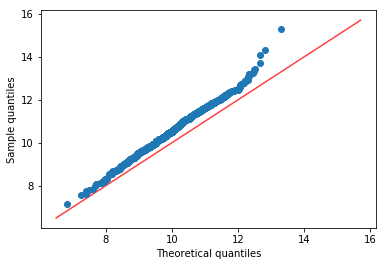

In [64]:
# Generate data from gamma distribution
y = st.gamma.rvs(m,loc=0,scale=1/float(N), size=len(x1))  # Sample 2: Y ~ t(5)

# Quantile-quantile plot
fig, ax = plt.subplots()
#plt.figure()
ax.scatter(np.sort(y), np.sort(x1))
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,color='red')
#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
plt.show()
plt.close()

In [18]:
from scipy.stats import gamma

In [54]:
n_sim = 1000
m = 100
dist_L_mh = []
T = 20
dim = 16
q = 6*np.sqrt(2*dim)+dim
N = 10

for j in range(0,n_sim):
    if j%10 == 0:
        print "Iteration",j
        
    cov_prop = 2*np.eye(dim)
    mu_target = np.array([0]*dim)
    cov_target = np.eye(dim)

    p_mh,m_mh,L_mh = p_estimation_threshold(N,m,T,normal,gaussian_proposal,Phi = Phi_norm, 
                                target_fn_kwargs = {'mu':mu_target,'cov':cov_target},
                                prop_fn_kwargs = {'cov':cov_prop})
    dist_L_mh.append(L_mh[m-1])

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Ite

In [56]:
x2 = -np.log(chi2.sf(dist_L_mh,df = 16))

(array([  26.,   85.,  160.,  238.,  227.,  158.,   72.,   21.,    9.,    4.]),
 array([  7.60969444,   8.20468705,   8.79967967,   9.39467228,
          9.98966489,  10.5846575 ,  11.17965011,  11.77464272,
         12.36963534,  12.96462795,  13.55962056]),
 <a list of 10 Patch objects>)

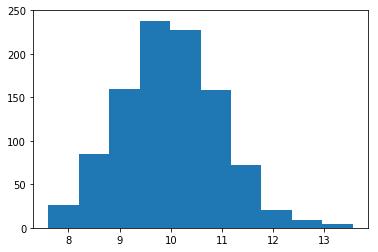

In [68]:
plt.hist(y)

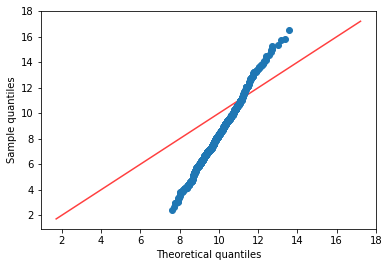

In [67]:
# Generate data from gamma distribution
y = st.gamma.rvs(m,loc=0,scale=1/float(N), size=len(x2))  # Sample 2: Y ~ t(5)

# Quantile-quantile plot
fig, ax = plt.subplots()
#plt.figure()
ax.scatter(np.sort(y), np.sort(x2))
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,color='red')
#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
plt.show()
plt.close()

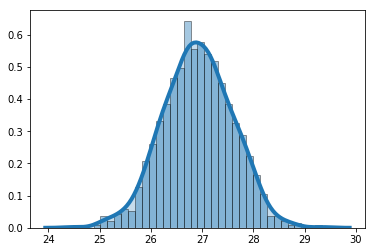

In [28]:
# Density Plot and Histogram of dist_L_bs
sns.distplot(dist_L_bs, hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 4})

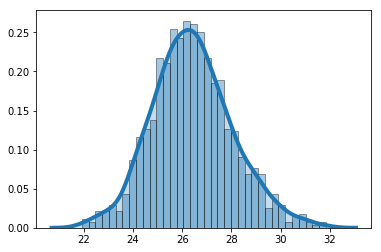

In [29]:
# Density Plot and Histogram of dist_L_mh
sns.distplot(dist_L_mh, hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 4})

### Exact distribution

In [93]:
def p_estimation_exact(N,M,Phi,dim):

    #m=1
    mean = np.array([0]*dim)
    cov = np.eye(dim)
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    all_L = [L]

    for m in range(1,M):   # as long as there are particles below q
        
        #t = np.random.exponential(1,1)
        #U = np.random.uniform(low=0,high=2*np.pi,size=1)
        #x_star = np.sqrt(2*t+L)*np.array([np.cos(U),np.sin(U)])
        
        z = np.random.multivariate_normal(mean,cov,1)
        u = np.random.uniform(low=0,high=1,size=1)
        R = np.sqrt(chi2.ppf(u+chi2.cdf(L,dim)*(1-u), dim, loc=0, scale=1))
        x_star = R*z/np.linalg.norm(z)
        
        x_star = [item for sublist in x_star for item in sublist]

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        all_L.append(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m,all_L

In [76]:
dim = 2
N = 10
M = 100

p,m,L = p_estimation_exact(N,M,Phi_norm,dim)

In [124]:
chi2.sf(6*np.sqrt(2*2)+2,2)

0.00091188196555451635

In [94]:
N = 10
dim = 16

M = 1000
m = 100
dist_L_exact = []

for j in range(0,M):
    if j%10 == 0:
        print "Iteration",j
    p_exact,m_exact,L_exact = p_estimation_exact(N,m,Phi_norm,dim)
    #print((L_exact[m-1]))
    dist_L_exact.append(L_exact[m-1])

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Ite

(array([  13.,   37.,  112.,  189.,  260.,  193.,  114.,   51.,   24.,    7.]),
 array([  7.19918631,   7.79516764,   8.39114898,   8.98713032,
          9.58311166,  10.17909299,  10.77507433,  11.37105567,
         11.96703701,  12.56301834,  13.15899968]),
 <a list of 10 Patch objects>)

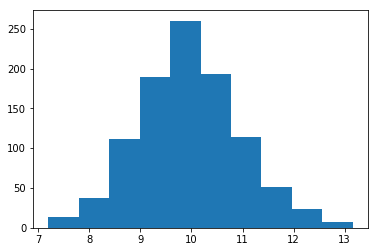

In [17]:
plt.hist(-np.log(chi2.sf(dist_L_exact,df = 16)))

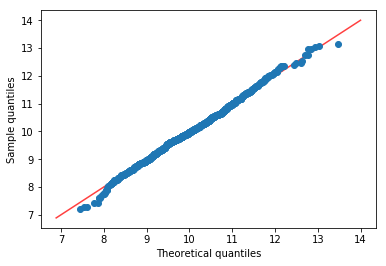

In [95]:
# Generate data from gamma distribution
y = st.gamma.rvs(m,loc=0,scale=1/float(N), size=len(x3))  # Sample 2: Y ~ t(5)

# Quantile-quantile plot

plt.figure()
plt.scatter(np.sort(y), np.sort(x3))
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0,color='red')
#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
plt.show()
plt.close()

(array([  17.,   57.,  156.,  240.,  248.,  186.,   66.,   19.,    9.,    2.]),
 array([  7.22384141,   7.89557804,   8.56731468,   9.23905131,
          9.91078794,  10.58252458,  11.25426121,  11.92599784,
         12.59773448,  13.26947111,  13.94120775]),
 <a list of 10 Patch objects>)

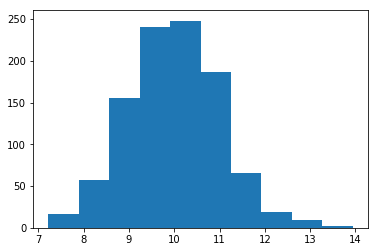

In [66]:
plt.hist(y)

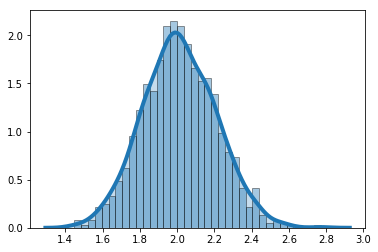

In [113]:
# Density Plot and Histogram of dist_L_mh
sns.distplot(dist_L_exact, hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 4})